# Tuning VAE

The aim of this notebook is to attempt to improve an already good "baseline" that we got working on day 1. The baseline is a simple Fully-connected VAE 
`[512 -> 256 -> 128 -> 16]: lr=0.001: nn.ReLU(): batch size=32` that was able to capture the data information well and generate both good reconstructions and generated images (realistic). The baseline models is simple FNN structure that we thought would handle the binary pixels well.
. The improvements that we are going to try are: $\beta$-warmup, lr-scheduler, `ELU` & `Mish` and `VGG` loss. 
* the starting point is a baseline FC-VAE...
* 
* the aim is to add some improvements
    * $\beta$`-warmup`: The $\beta$-warmup technique gradually increases the weight of the KL divergence term ($\beta$) in the VAE loss function during the initial training epochs. This approach helps to stabilize training by initially allowing the model to focus more on reconstructing the input data accurately before gradually enforcing the latent space regularity. 
    * `lr-scheduler`: improve training - helps to fine-tune the model by taking larger steps in the beginning when far from the optimal weights and smaller steps later to avoid overshooting the minimum of the loss function
    * `different activations`: Exploring different activation functions like ELU (Exponential Linear Unit) and Mish aims to improve model performance by enhancing non-linearities and the flow of gradients during backpropagation

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader

from atlaswildfiretool.generative.model import VAE
from atlaswildfiretool.generative.plotting import plot_batch_recon_images
from atlaswildfiretool.generative.utils import sequential_train_val_split, get_device
from atlaswildfiretool.generative.training import train_vae
from atlaswildfiretool.generative.dataset import WildfireImageDataSet

#### Data Loading
* A user will need to download the wildfire data available at `https://companyname.sharepoint.com/sites/projectname/Shared%20Documents/example-document.docx`
* the current set up runs given that the `.npy` wildfire data is stored in a `data/` DIR.

In [2]:
# Specify the paths to the data
train_path = "data/Ferguson_fire_train.npy"  #

# Load the data as numpy arrays
train = np.load(train_path)

# Investigating the shape of the data
print(f"Shape of train data: {train.shape}")

Shape of train data: (12500, 256, 256)


In [3]:
# Splitting data into train and val using sequential jump
train, val = sequential_train_val_split(train, sequence_jump=3)


** (split) data info (w/ jump=3)**
X_train: (11111, 256, 256)
X_val: (1389, 256, 256)


In [4]:
# Initializing WildfireImageDataset
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Initialize the datasets with the transform
train_dataset = WildfireImageDataSet(train, transform=transform)
val_dataset = WildfireImageDataSet(val, transform=transform)

print("Number of training images: " + str(len(train_dataset)))
print("Number of validation images: " + str(len(val_dataset)))

Number of training images: 11111
Number of validation images: 1389


In [5]:
# Define batch size
batch_size = 32

In [6]:
# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [7]:
device = get_device()

No GPU available! (device = cpu)


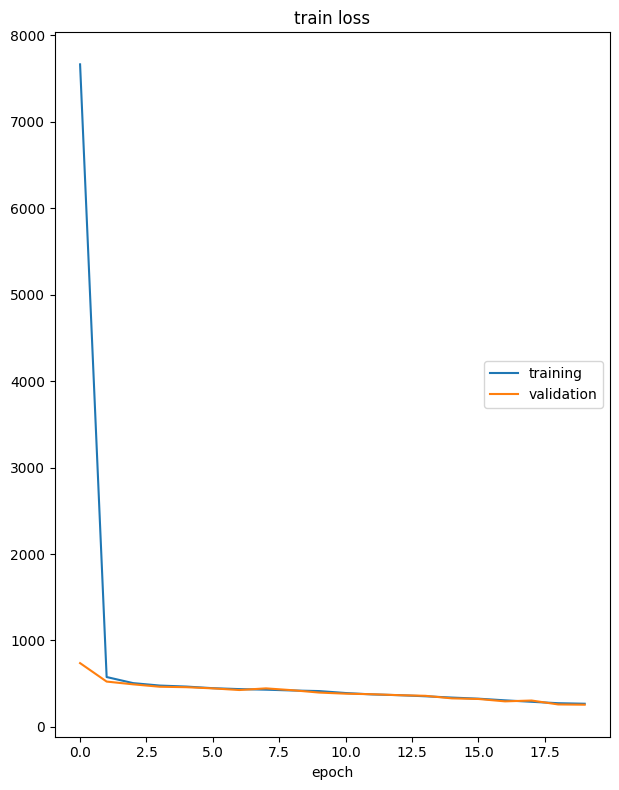

Epoch: 19/20 | Batch: 348/348: 100%|██████████| 6960/6960 [10:48<00:00, 10.73batch/s, loss=149]

train loss
	training         	 (min:  267.833, max: 7664.511, cur:  267.833)
	validation       	 (min:  256.677, max:  737.701, cur:  256.677)


In [8]:
# Initializing Baseline VAE
baseline_vae = VAE(
    input_image_dims=(1, 256, 256),
    hidden_layers=[512, 256, 128],
    latent_dims=16,
    activation=nn.ReLU,
    device=device,
).to(device)

# Defining optimiezer
optimizer = torch.optim.Adam(baseline_vae.parameters(), lr=1e-3)

# Training the optimizer model
baseline_vae, baseline_train_losses, baseline_val_losses = train_vae(
    n_epochs=20,
    model=baseline_vae,
    optimizer=optimizer,
    scheduler=None,
    train_loader=train_loader,
    val_loader=val_loader,
    model_save_path=None,
    use_liveloss=True,
    device=device,
)

random idxs = tensor([31,  3, 30, 11, 11])


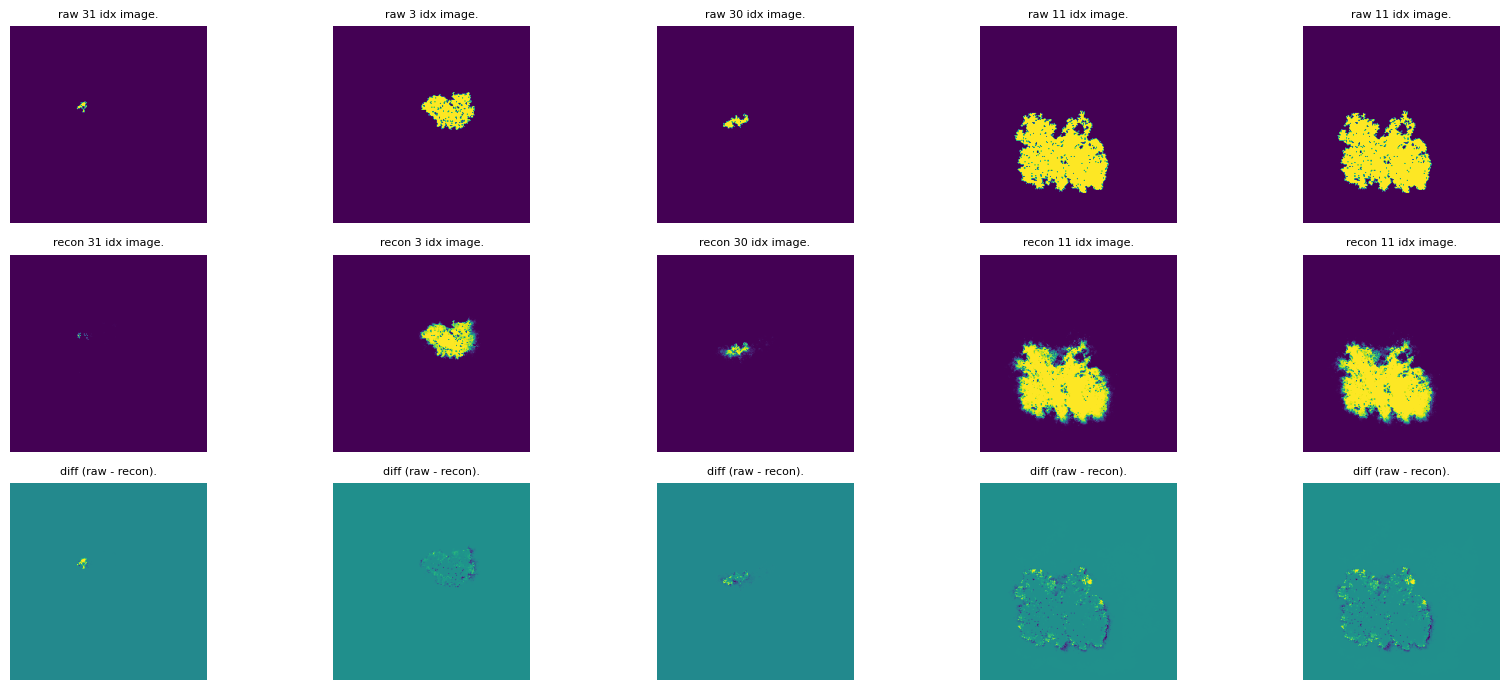

In [33]:
plot_batch_recon_images(baseline_vae, train_loader, num_images=5, device=device)

## lr_scheduler

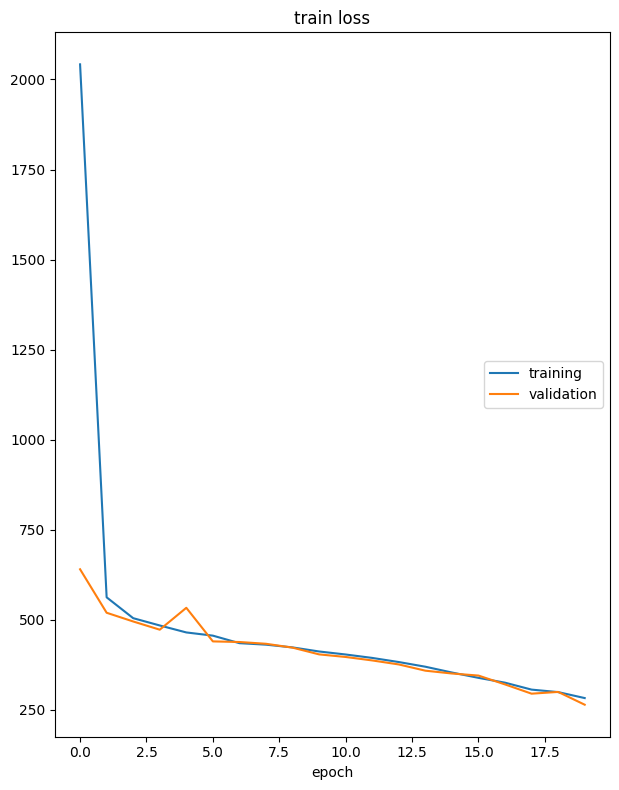

Epoch: 19/20 | Batch: 348/348: 100%|██████████| 6960/6960 [11:15<00:00, 10.31batch/s, loss=137]

train loss
	training         	 (min:  282.816, max: 2041.899, cur:  282.816)
	validation       	 (min:  264.387, max:  640.339, cur:  264.387)
done


In [15]:
lr_vae = VAE(
    input_image_dims=(1, 256, 256),
    hidden_layers=[512, 256, 128],
    latent_dims=16,
    activation=nn.ReLU,
    device=device,
).to(device)

optimizer = torch.optim.Adam(lr_vae.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5, verbose=True
)

lr_vae, lr_train_losses, lr_val_losses = train_vae(
    n_epochs=20,
    model=lr_vae,
    optimizer=optimizer,
    scheduler=scheduler,  # Adding scheduler
    train_loader=train_loader,
    val_loader=val_loader,
    model_save_path=None,
    use_liveloss=True,
    device=device,
)
print("done")

random idxs = tensor([14, 27,  4,  1, 10])


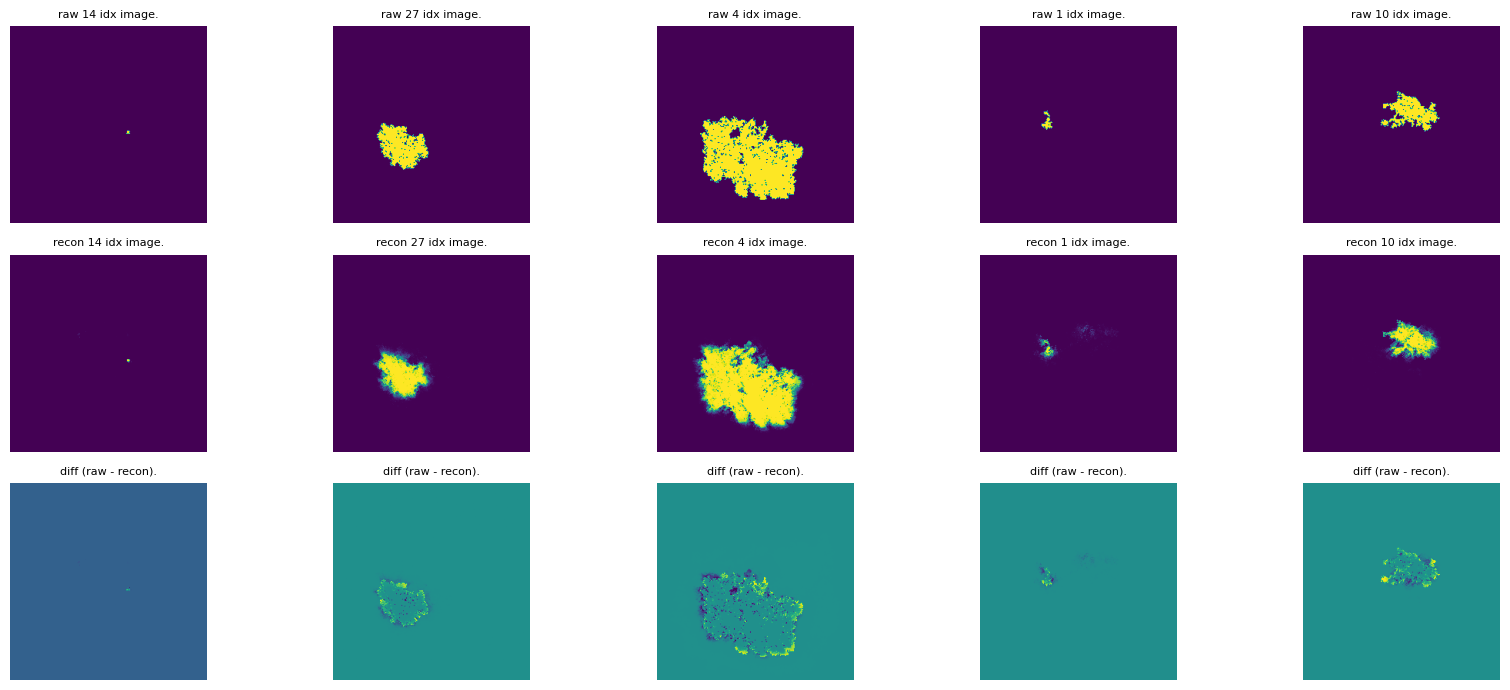

In [ ]:
plot_batch_recon_images(lr_vae, train_loader, num_images=5, device=device)

## Mish activation

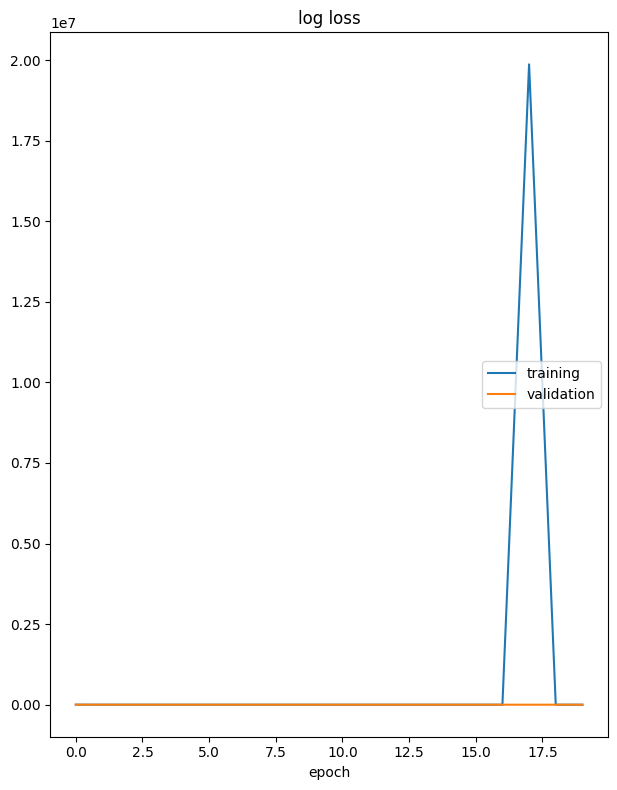

log loss
	training         	 (min:  227.622, max: 19869496.540, cur:  227.622)
	validation       	 (min:  219.058, max:  745.361, cur:  219.058)
Epoch 20, Training Loss: 227.6220, Validation Loss: 219.0583
done


In [38]:
mish_vae = VAE(
    input_image_dims=(1, 256, 256),
    hidden_layers=[512, 256, 128],
    latent_dims=16,
    activation=nn.Mish,
    device=device,
).to(device)

optimizer = torch.optim.Adam(mish_vae.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5, verbose=True
)

mish_vae, mish_train_losses, mish_val_losses = train_vae(
    n_epochs=20,
    model=mish_vae,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    model_save_path=None,
    use_liveloss=True,
    device=device,
)

print("done")

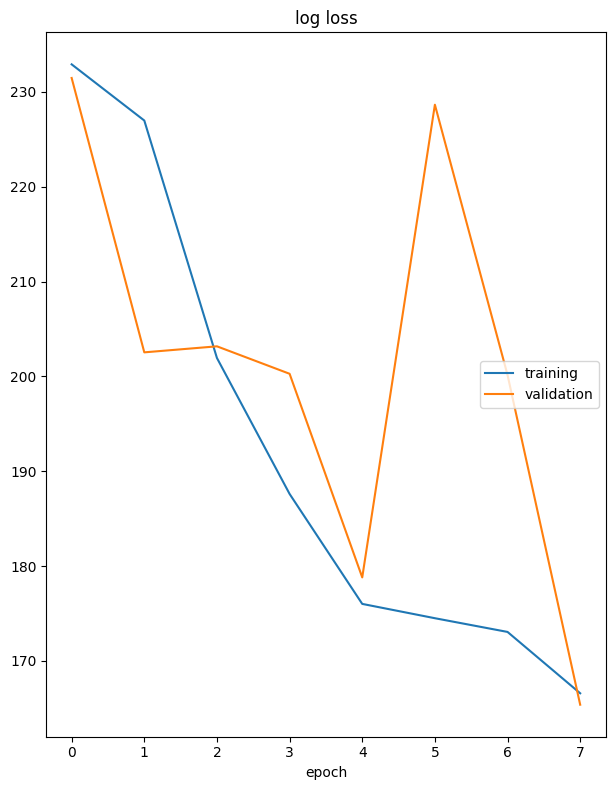

log loss
	training         	 (min:  166.579, max:  232.899, cur:      nan)
	validation       	 (min:  165.375, max:  231.462, cur:      nan)
Epoch 10, Training Loss: nan, Validation Loss: nan
done


In [39]:
mish_vae_30, mish_train_losses_30, mish_val_losses_30 = train_vae(
    n_epochs=10,
    model=mish_vae,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    model_save_path=None,
    use_liveloss=True,
    device=device,
)
print("done")

random idxs = tensor([ 6, 21, 10,  6,  1])


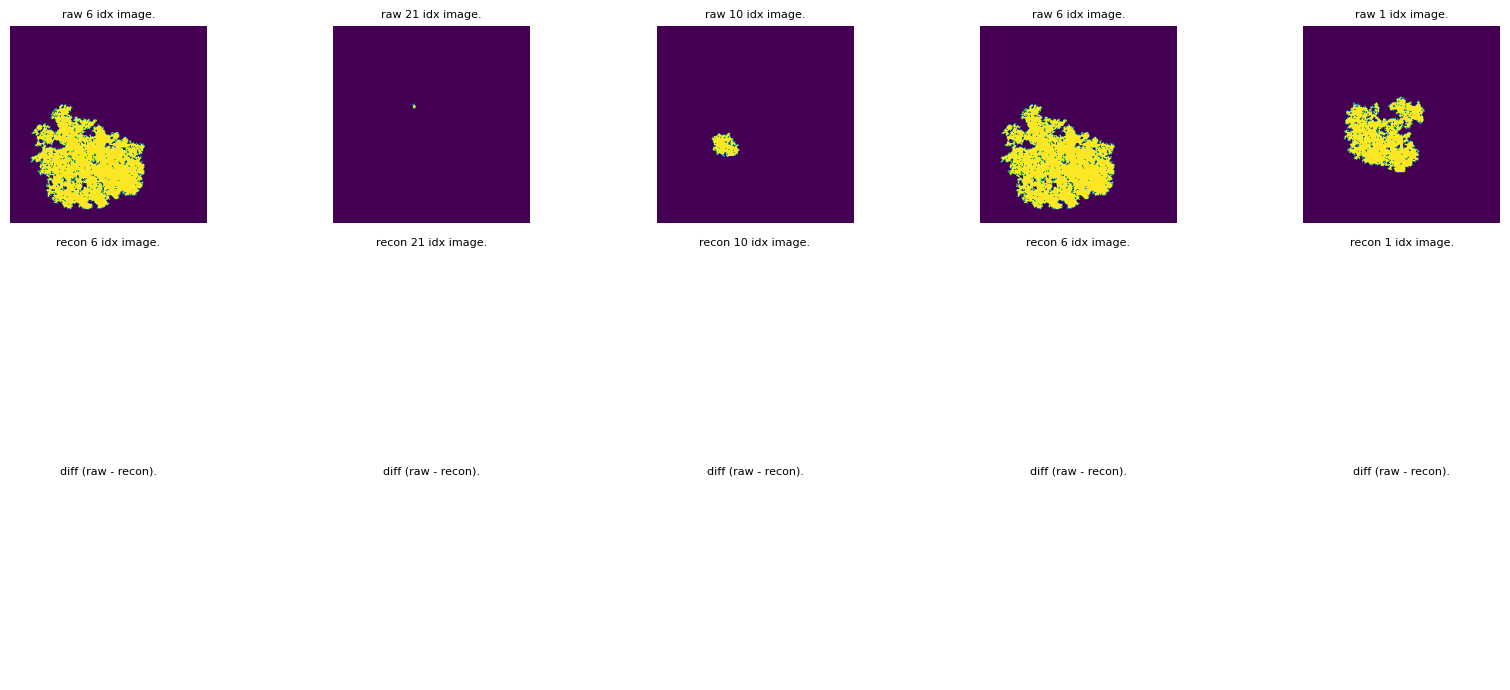

In [44]:
plot_batch_recon_images(mish_vae, train_loader, num_images=5, device=device)

## LeakyReLU

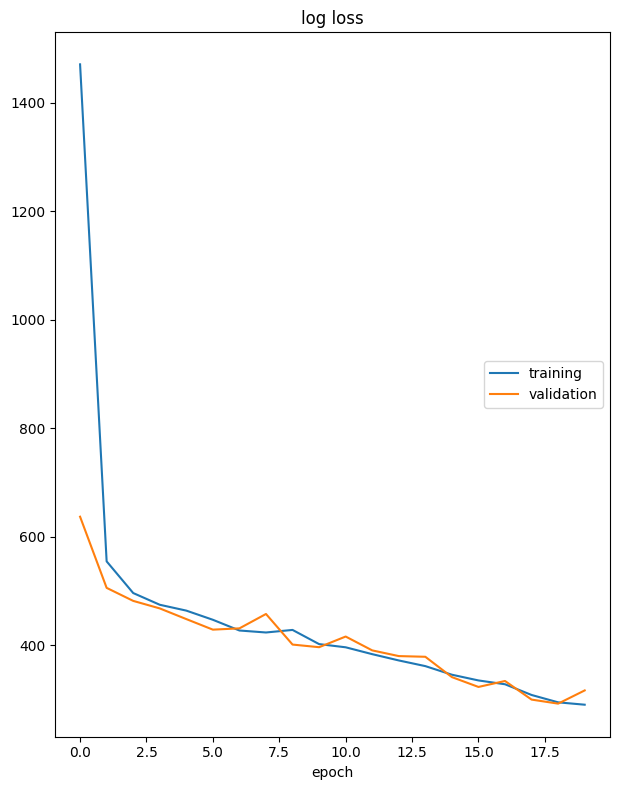

log loss
	training         	 (min:  290.749, max: 1470.863, cur:  290.749)
	validation       	 (min:  292.713, max:  637.201, cur:  317.064)
Epoch 20, Training Loss: 290.7489, Validation Loss: 317.0636
done


In [47]:
leaky_vae = VAE(
    input_image_dims=(1, 256, 256),
    hidden_layers=[512, 256, 128],
    latent_dims=16,
    activation=nn.LeakyReLU,  # Changing to LeakyReLU
    device=device,
).to(device)

optimizer = torch.optim.Adam(leaky_vae.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5, verbose=True
)

leaky_vae, leaky_train_losses, leaky_val_losses = train_vae(
    n_epochs=20,
    model=leaky_vae,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    model_save_path=None,
    use_liveloss=True,
    device=device,
)
print("done")

random idxs = tensor([30,  2, 21, 31,  6])


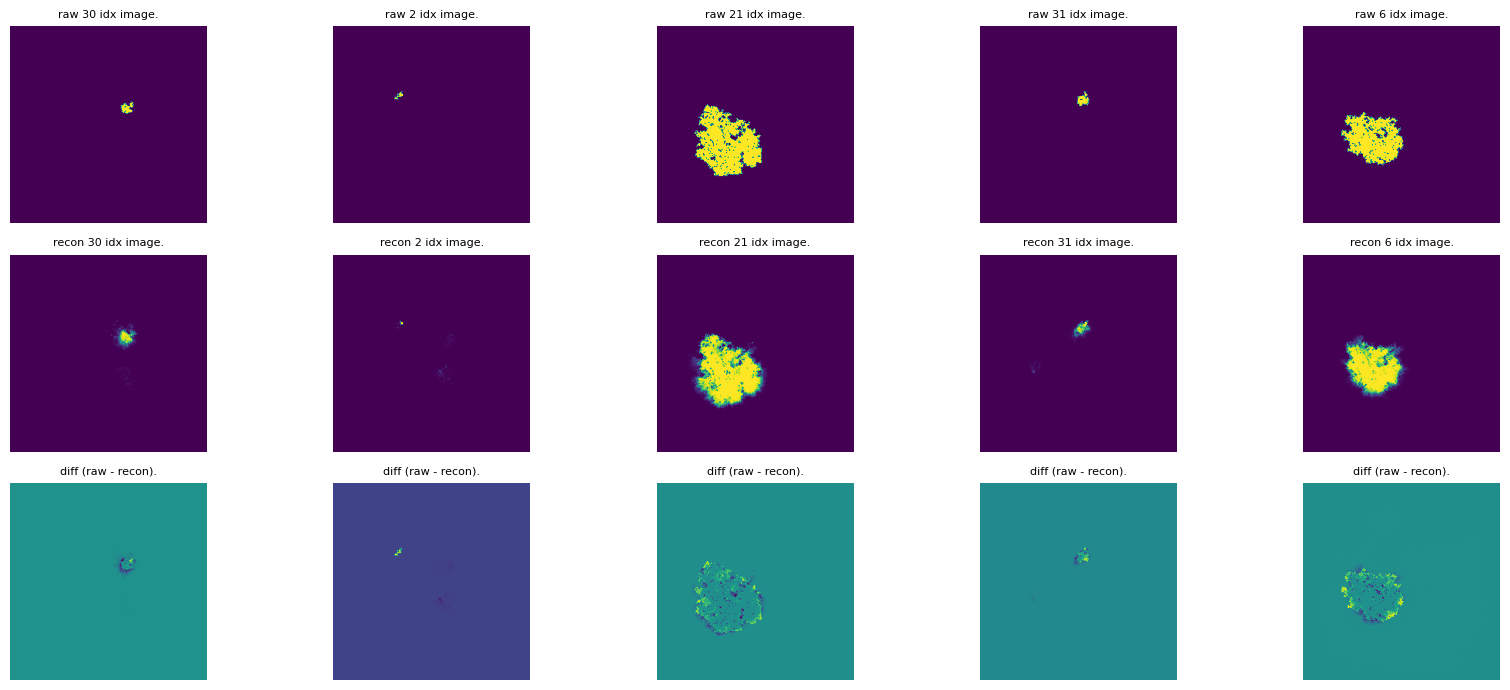

In [51]:
plot_batch_recon_images(leaky_vae, train_loader, num_images=5, device=device)

## ELU Activation

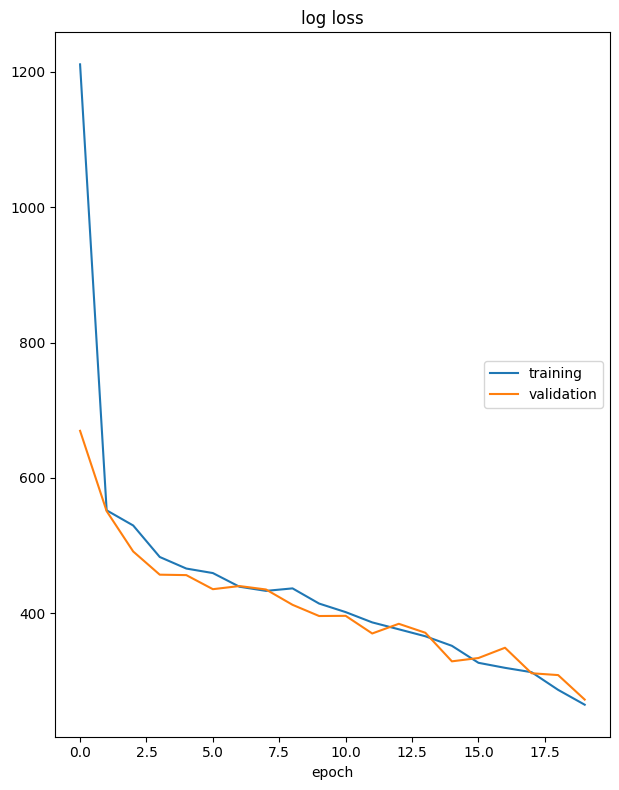

log loss
	training         	 (min:  265.129, max: 1210.840, cur:  265.129)
	validation       	 (min:  272.722, max:  669.607, cur:  272.722)
Epoch 20, Training Loss: 265.1288, Validation Loss: 272.7218
done


In [76]:
elu_vae = VAE(
    input_image_dims=(1, 256, 256),
    hidden_layers=[512, 256, 128],
    latent_dims=16,
    activation=nn.ELU,
    device=device,
).to(device)

optimizer = torch.optim.Adam(elu_vae.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5, verbose=True
)

elu_vae, elu_train_losses, elu_val_losses = train_vae(
    n_epochs=20,
    model=elu_vae,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    model_save_path=None,
    use_liveloss=True,
    device=device,
)
print("done")

random idxs = tensor([ 1,  5, 15, 13, 21])


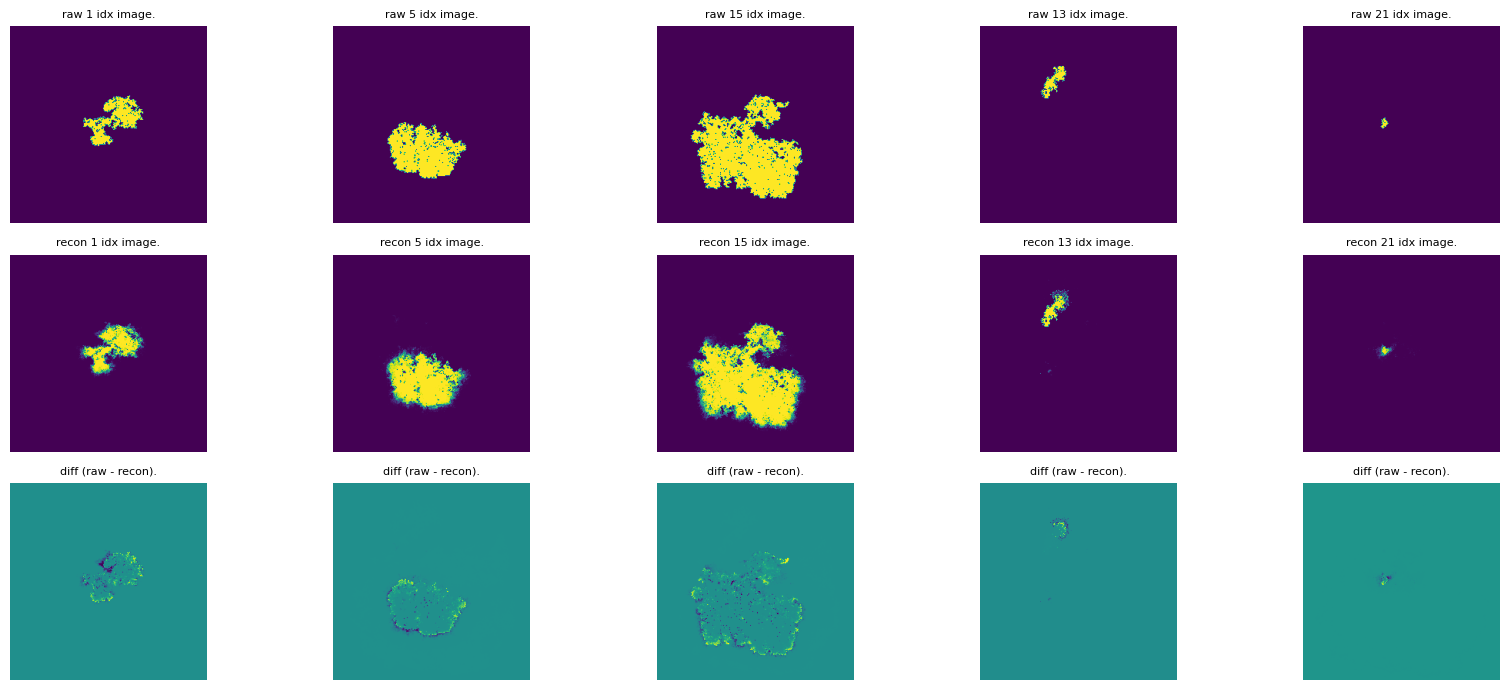

In [78]:
plot_batch_recon_images(elu_vae, train_loader, num_images=5, device=device)

## $\beta$ warmup

In [23]:
# this wasnt put into a function as we needed to do more experiments but were not able to.
def beta_train_vae(
    autoencoder,
    train_loader,
    val_loader=None,
    kl_div_on=True,
    lr=1e-3,
    epochs=10,
    device="cpu",
    use_scheduler=False,
    beta_max=1.0,
    warmup_epochs=10,
):
    """
    Train the VAE.

    Args:
        autoencoder (nn.Module): VAE model.
        train_loader (DataLoader): DataLoader for the training set.
        val_loader (DataLoader, optional): DataLoader for the validation set. Default is None.
        kl_div_on (bool): Whether to include KL divergence in the loss.
        lr (float): Learning rate.
        epochs (int): Number of training epochs.
        device (str): Device to run the model on ('cpu' or 'cuda').

    Returns:
        nn.Module: Trained VAE model.
        list: Training losses.
        list or None: Validation losses if val_loader is provided, otherwise None.
    """
    opt = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    scheduler = (
        torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode="min", factor=0.1, patience=5, verbose=True
        )
        if use_scheduler
        else None
    )
    liveloss = PlotLosses()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        logs = {}

        # Calculate current beta
        beta = min(beta_max, epoch / warmup_epochs)

        # Training phase
        autoencoder.train()
        train_loss = 0
        for batch in tqdm(train_loader):
            batch = batch.to(device).float()
            opt.zero_grad()
            x_hat, KL = autoencoder(batch)
            loss = ((batch - x_hat) ** 2).sum() + (beta * KL)
            loss.backward()
            train_loss += loss.item()
            opt.step()

        avg_train_loss = train_loss / len(train_loader.dataset)
        logs["log loss"] = avg_train_loss
        train_losses.append(avg_train_loss)

        if val_loader:
            # Validation phase
            autoencoder.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_loader:
                    batch = batch.to(device).float()
                    x_hat, KL = autoencoder(batch)
                    loss = ((batch - x_hat) ** 2).sum() + (beta * KL)
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader.dataset)
            logs["val_log loss"] = avg_val_loss
            val_losses.append(avg_val_loss)

        liveloss.update(logs)
        liveloss.send()

        if val_loader:
            print(
                f"Epoch {epoch + 1}, Beta: {beta:.4f}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}"
            )
        else:
            print(
                f"Epoch {epoch + 1}, Beta: {beta:.4f}, Training Loss: {avg_train_loss:.4f}"
            )

        if use_scheduler:
            scheduler.step(avg_train_loss)

    return autoencoder, train_losses, val_losses if val_loader else None

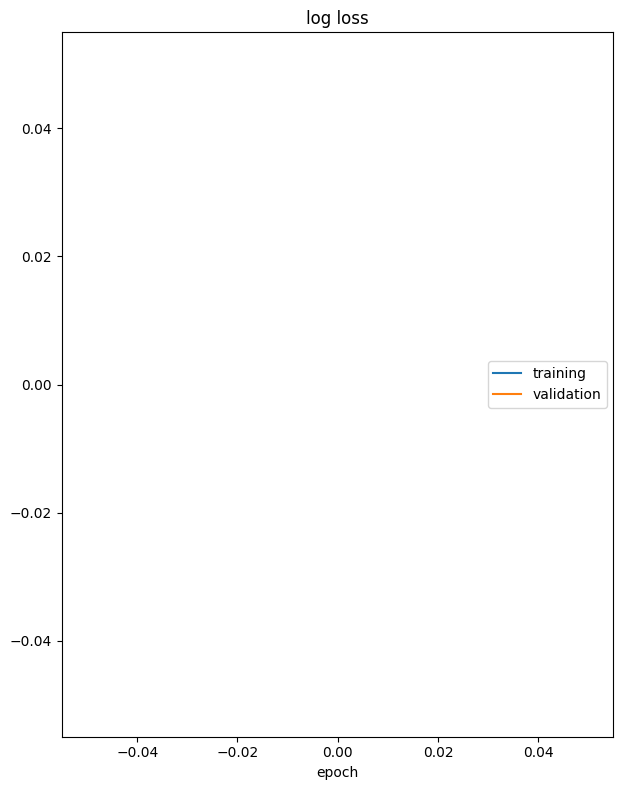

log loss
	training         	 (min:      nan, max:      nan, cur:      nan)
	validation       	 (min:      nan, max:      nan, cur:      nan)
Epoch 1, Beta: 0.0000, Training Loss: nan, Validation Loss: nan
done


In [26]:
beta_vae = VAE(
    input_image_dims=(1, 256, 256),
    hidden_layers=[512, 256, 128],
    latent_dims=16,
    activation=nn.ReLU,
    device=device,
).to(device)

beta_vae, beta_train_losses, beta_val_losses = beta_train_vae(
    autoencoder=beta_vae,
    train_loader=train_loader,
    val_loader=val_loader,
    kl_div_on=True,
    lr=1e-3,
    epochs=1,
    device=device,
    use_scheduler=True,
    beta_max=1.0,
    warmup_epochs=10,
)
print("done")

| Model Name   | Model Arch | Epochs | Train Loss | Val Loss | Reconstruction | Final Comments   |
|--------------|------------|--------|------------|----------|----------------|------------------|
| Baseline | (512->256->128->64->16); stability; ReLU; batchsize: 32; loss = mse + KL; scheduler=F| 20 | 267.833 | 256.677 | Good shape, bleeding edges | Satisfactory results; stable training but maybe slow |
| lr_scheduler  | (512->256->128->64->16); stability; ReLU; batchsize: 32; loss = mse + KL; scheduler=T | 20 | 284.498 | 272.728 | Good shape, bleeding edges | Performance comparable to baseline (scheduler probably not activated), potential for improved training |
| Mish activation | (512->256->128->64->16); stability; Mish; batchsize: 32; loss = mse + KL; scheduler=T | 30 | nan | nan | No reconstruction | Faster training but sporadic loss -> unreliable  |
| LeakyReLU activation | (512->256->128->64->16); stability; LeakyReLU; batchsize: 32; loss = mse + KL; scheduler=T | 20 | 290.749 | 317.064 | Good shape, bleeding edges | Stable training, but higher loss than ReLU  |
| ELU activation | (512->256->128->64->16); stability; ELU; batchsize: 32; loss = mse + KL; scheduler=T | 20 | 265.129 | 272.722 | Good shape, little bleeding around edges| Improvement in terms of reconstruction and training speed |
| beta warmup | (512->256->128->64->16); stability; ReLU; batchsize: 32; loss = mse + beta*KL; scheduler=T | 20 | nan | nan | No reconstruction | Unsuitable |



### Conclusion:

* keep in the `lr-scheduler`. This has no adverse effects and it may help at larger epochs.
* test `ELU` to the final arch and compare it to `ReLU`.